# Format State Parks

This notebook picks up after `format_national_parks.ipynb` to format the state park data.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import os

data_dir = "/pool0/home/steinadi/data/drought/DatabaseDrafts"

Populating the interactive namespace from numpy and matplotlib


### Explore Data

Path notes from `explore.ipynb`

In [2]:
# Good to go
# ----------
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Overnight", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Total", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Day Use", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Day User Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Overnight Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)

# Needs splicing
# --------------
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Day Use", skiprows=np.arange(1,6), index_col=0, header=1) # some totals that I think can be cut out?
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Overnight", skiprows=np.arange(1,7), index_col=2, header=1) # also some strange totals

Read in data

In [3]:
# uses year-park multi-index with months for columns
wa_overnight = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Overnight", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
wa_total = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Total", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
wa_day_use = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Day Use", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)

# uses park-month_num-year for index with sums for column
or_day_user_monthly = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Day User Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)
or_overnight_monthly = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Overnight Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)

# uses park/totals for index, year for columns
or_annual_day = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Day Use", skiprows=np.arange(1,6), index_col=0, header=1)
or_annual_overnight = pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Overnight", skiprows=np.arange(1,7), index_col=2, header=1)

Alright, in `format_national_parks.ipynb`, I got the netcdf to have dimensions of time and park, so I want to repeat that here I think.

First I want to take care of the splicing needs of the last two dataframes

After second thought, I want to keep those totals, could be useful, might as well not throw out data.

let's get a list of park names (for WA, we don't have an issue with repeats via capitalization or not, but we do have that issue for OR)

In [4]:
wa_parks = []

for data in [wa_overnight, wa_total, wa_day_use]:
    for dex in data.index:
        park = dex[2]
        if park not in wa_parks:
            wa_parks.append(park)

In [5]:
or_parks = []

for data in [or_day_user_monthly, or_overnight_monthly]:
    for dex in data.index:
        park = dex[0].upper()
        if park not in or_parks:
            or_parks.append(park)

for data in [or_annual_day, or_annual_overnight]:
    for dex in data.index:
        if isinstance(dex, str):
            park = dex.upper()
            if park not in or_parks:
                or_parks.append(park)

Got that. Now let's check our times. 

WA data goes from 2014 to 2020    
OR data goes from 1989 to 2021 for monthly, and 2002 to 2020 for annual

Hmmm ... let's see whether the annual and monthly data adds up for OR, (because if they do, then I might as well only store the monthly data and just compute the annual data later to make my coordinates easier in the netcdf)

In [6]:
or_day_user_monthly.head()

SumOfattendance
property                          recordedMonth recordedYear                 
Agate Beach State Recreation Site 7             1989                  37656.0
                                  8             1989                  35544.0
                                  9             1989                  28316.0
                                  10            1989                  16580.0
                                  11            1989                  11792.0

In [7]:
or_reproduced_day_annual = or_day_user_monthly.groupby(['recordedYear', 'property']).sum()
or_reproduced_day_annual.loc[2020]

,SumOfattendance
property,
Agate Beach State Recreation Site,158136.0
Alderwood State Wayside,51058.0
Alfred A. Loeb State Park,122526.0
Arcadia Beach State Recreation Site,126172.0
Arizona Beach,43130.0
...,...
Winchuck State Recreation Site,12264.0
Wyeth State Recreation Area,145290.0
Yachats Ocean Road State Natural Site,324644.0


In [8]:
or_annual_day.iloc[:,-1]

Location
AGATE BEACH STATE RECREATION SITE           158136.0
ALFRED A LOEB STATE PARK                    122526.0
ALSEA BAY HISTORIC INTERPRETIVE CENTER           NaN
ARCADIA BEACH STATE RECREATION SITE         126172.0
ARIZONA BEACH                                43130.0
                                             ...    
WARM SPRINGS STATE RECREATION SITE          215644.0
WHITE RIVER FALLS STATE PARK                 45044.0
Total Mountain Region                      9833322.5
NaN                                              NaN
Total Statewide                           42912867.5
Name: 2020 (updated 2-10-2021), Length: 186, dtype: float64

Alright, checked a few by eye (I know not very rigorous but didn't want to spend a bunch of time on this) and they are matching up, so I'll just keep the monthly totals and make life easier for me.

So let's make 2 datasets, one for WA parks and one for OR parks, just to keep things organized since they are state parks anywho. I'll have them as both monthly intervals for their respective time periods.

### WA State Parks

In [9]:
months = list(wa_day_use.columns)[:-1]
print(months)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [10]:
wa_years = list(set([dex[0] for dex in wa_day_use.index]))
wa_years.sort()
wa_years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [11]:
wa_day_use.head()

January  February    March  April      May  \
Year State Park Name                                                        
2020 WA    Alta Lake               0.0       0.0      0.0    0.0   8402.0   
           Anderson Lake           0.0       0.0      0.0    0.0    218.0   
           Battle Ground Lake  14728.0   17202.0  19168.0  324.0   8686.0   
           Bay View             6784.0    9820.0  11910.0  271.0  13775.0   
           Beacon Rock          5336.0    8809.0   1460.0    0.0      0.0   

                                  June     July   August  September  October  \
Year State Park Name                                                           
2020 WA    Alta Lake           18243.0  24301.0  27364.0    11644.0   8178.0   
           Anderson Lake         328.0   4978.0   5014.0     3488.0   3690.0   
           Battle Ground Lake  36410.0  59367.0  52580.0    22352.0  23072.0   
           Bay View            19238.0  27856.0  28266.0    14400.0  13940.0   
           Beacon Rock         41718.0  46082.0  46119.0    26095.0  26375.0   

                               November  December  Grand Total  
Year State Park Name                                            
2020 WA    Alta Lake                0.0       0.0        98132  
           Anderson Lake            0.0       0.0        17716  
           Battle Ground Lake   18788.0   17899.0       290576  
           Bay View             11695.0   10995.0       168950  
           Beacon Rock          19519.0   14061.0       235574

In [12]:
revised_wa_day_park_visits = pd.DataFrame(index=pd.date_range(start=f"{wa_years[0]}", end=f"{wa_years[-1]+1}", freq="MS"), columns=wa_parks)

errors = []

for park in wa_parks:
    for year in wa_years:
        for month_num, month in enumerate(months):
            try:
                revised_wa_day_park_visits[park].loc[f'{year}-{month_num+1}-01'] = wa_day_use.loc[year, 'WA', park][month]
            except:
                errors.append((park, year, month))

In [13]:
errors

[('Alta Lake', 2015, 'January'),
 ('Alta Lake', 2015, 'February'),
 ('Alta Lake', 2015, 'March'),
 ('Alta Lake', 2015, 'April'),
 ('Alta Lake', 2015, 'May'),
 ('Alta Lake', 2015, 'June'),
 ('Alta Lake', 2015, 'July'),
 ('Alta Lake', 2015, 'August'),
 ('Alta Lake', 2015, 'September'),
 ('Alta Lake', 2015, 'October'),
 ('Alta Lake', 2015, 'November'),
 ('Alta Lake', 2015, 'December'),
 ('Fort Worden Conf Ctr', 2014, 'January'),
 ('Fort Worden Conf Ctr', 2014, 'February'),
 ('Fort Worden Conf Ctr', 2014, 'March'),
 ('Fort Worden Conf Ctr', 2014, 'April'),
 ('Fort Worden Conf Ctr', 2014, 'May'),
 ('Fort Worden Conf Ctr', 2014, 'June'),
 ('Fort Worden Conf Ctr', 2014, 'July'),
 ('Fort Worden Conf Ctr', 2014, 'August'),
 ('Fort Worden Conf Ctr', 2014, 'September'),
 ('Fort Worden Conf Ctr', 2014, 'October'),
 ('Fort Worden Conf Ctr', 2014, 'November'),
 ('Fort Worden Conf Ctr', 2014, 'December'),
 ('Fort Worden Conf Ctr', 2015, 'January'),
 ('Fort Worden Conf Ctr', 2015, 'February'),
 ('Fort

Fairly certain this is just where data is missing, since there are several holes in the data, which is fine. (Along with parks being renamed overtime or opened or closed ...)

In [14]:
revised_wa_day_park_visits

,Alta Lake,Battle Ground Lake,Bay View,Beacon Rock,Belfair,Birch Bay,Blake Island,Blind Island,Bogachiel,Bridgeport,...,IC - Lewis & Clark,IC - Marine Science Ctr,IC - Mount St. Helens Visitor Ctr,IC - Sacajawea,IC - Spokane House,Stretch Point,IC - Deception Pass CCC,Westhaven,Wolfe Property,North Jetty
2014-01-01,NaN,5159.0,2433.0,9143.0,4706.0,28763.0,604.0,51.0,2878.0,NaN,...,NaN,830.0,1430.0,NaN,NaN,304.0,NaN,10235.0,1765.0,29051.0
2014-02-01,NaN,9052.0,8448.0,5410.0,3711.0,36534.0,676.0,97.0,3049.0,NaN,...,829.0,974.0,857.0,NaN,NaN,327.0,NaN,6651.0,1743.0,19966.0
2014-03-01,NaN,15631.0,NaN,13200.0,3396.0,50878.0,2954.0,216.0,5041.0,NaN,...,1942.0,1087.0,3534.0,NaN,NaN,506.0,3.0,10001.0,2375.0,26906.0
2014-04-01,4303.0,20461.0,NaN,18305.0,4261.0,52669.0,6169.0,288.0,3953.0,3526.0,...,1911.0,1104.0,3756.0,884.0,NaN,508.0,152.0,11150.0,3084.0,35610.0
2014-05-01,15653.0,27406.0,NaN,23987.0,6547.0,76693.0,12831.0,446.0,6441.0,6126.0,...,3547.0,2512.0,9788.0,3443.0,NaN,650.0,292.0,15670.0,3186.0,40473.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,11644.0,22352.0,14400.0,26095.0,39623.0,72826.0,7090.0,73.0,11367.0,6486.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,8178.0,23072.0,13940.0,26375.0,33141.0,51410.0,4160.0,123.0,4085.0,7860.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,0.0,18788.0,11695.0,19519.0,26312.0,43399.0,1672.0,249.0,2730.0,2054.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,0.0,17899.0,10995.0,14061.0,23388.0,41228.0,2296.0,149.0,3728.0,1634.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cool, that worked, let's get that into a dataset and then loop through the rest of the WA state park data and get it stored away into a netcdf.

In [15]:
wa_park_visits_ds = xr.Dataset(
    coords = dict(
        time = revised_wa_day_park_visits.index,
        park = wa_parks,
    ),
    data_vars = dict(
        day_visits=(["time", "park"], revised_wa_day_park_visits.values)
    )
)
wa_park_visits_ds

<xarray.Dataset>
Dimensions:     (time: 85, park: 194)
Coordinates:
  * time        (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-01-01
  * park        (park) <U33 'Alta Lake' 'Battle Ground Lake' ... 'North Jetty'
Data variables:
    day_visits  (time, park) object nan 5.159e+03 2.433e+03 ... nan nan nan

In [16]:
wa_park_visits_ds['day_visits'].attrs = {
    "Source": "https://parks.state.wa.us/1165/Visitation-reports",
    "Original Download": "3/9/21 by K.Hegewisch",
    "Reformatted": "2/17/22 by A. Stein",
    "Notes": "Excludes all day use, moorage, and Retreat Centers"
}

In [17]:
errors = {'overnight':[], 'total':[]}

for data, data_name in zip([wa_overnight, wa_total], ['overnight', 'total']):
    revised_wa_park_visits = pd.DataFrame(index=pd.date_range(start=f"{wa_years[0]}", end=f"{wa_years[-1]+1}", freq="MS"), columns=wa_parks)

    for park in wa_parks:
        for year in wa_years:
            for month_num, month in enumerate(months):
                try:
                    revised_wa_park_visits[park].loc[f'{year}-{month_num+1}-01'] = data.loc[year, 'WA', park][month]
                except:
                    errors[data_name].append((park, year, month))
                    
    wa_park_visits_ds[data_name] = (["time", "park"], revised_wa_park_visits.values)

In [18]:
wa_park_visits_ds

<xarray.Dataset>
Dimensions:     (time: 85, park: 194)
Coordinates:
  * time        (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-01-01
  * park        (park) <U33 'Alta Lake' 'Battle Ground Lake' ... 'North Jetty'
Data variables:
    day_visits  (time, park) object nan 5.159e+03 2.433e+03 ... nan nan nan
    overnight   (time, park) object nan 166.0 680.0 38.0 ... nan nan nan nan
    total       (time, park) object nan 5.325e+03 3.113e+03 ... nan nan nan

Looking alright, let's do a quick inspection

In [19]:
wa_park_visits_ds['day_visits'].sel(park='Alta Lake', time='2020')

<xarray.DataArray 'day_visits' (time: 12)>
array([0.0, 0.0, 0.0, 0.0, 8402.0, 18243.0, 24301.0, 27364.0, 11644.0,
       8178.0, 0.0, 0.0], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
    park     <U33 'Alta Lake'
Attributes:
    Source:             https://parks.state.wa.us/1165/Visitation-reports
    Original Download:  3/9/21 by K.Hegewisch
    Reformatted:        2/17/22 by A. Stein
    Notes:              Excludes all day use, moorage, and Retreat Centers

In [20]:
wa_day_use.loc[:, 'WA', 'Alta Lake']

,,,January,February,March,April,May,June,July,August,September,October,November,December,Grand Total
Year,State,Park Name,,,,,,,,,,,,,
2020,WA,Alta Lake,0.0,0.0,0.0,0.0,8402.0,18243.0,24301.0,27364.0,11644.0,8178.0,0.0,0.0,98132
2019,WA,Alta Lake,0.0,0.0,0.0,7954.0,13512.0,14721.0,21214.0,18504.0,9752.0,5917.0,0.0,0.0,91574
2018,WA,Alta Lake,NaN,NaN,NaN,8675.0,11185.0,17861.0,22804.0,18006.0,10820.0,7586.0,NaN,NaN,96937
2017,WA,Alta Lake,NaN,NaN,NaN,8691.0,13391.0,14406.0,21784.0,16590.0,9660.0,7074.0,NaN,NaN,91596
2016,WA,Alta Lake,NaN,NaN,NaN,NaN,NaN,NaN,21407.0,17474.0,10852.0,5250.0,NaN,NaN,54983
2014,WA,Alta Lake,NaN,NaN,NaN,4303.0,15653.0,21317.0,10070.0,14453.0,3536.0,NaN,NaN,NaN,69332


Looks good. Resolved an issue I had in how I was indexing and we look all good now after iterating through each year and checking that the data matched (which it did).

In [21]:
wa_park_visits_ds['overnight'].attrs = {
    "Source": "https://parks.state.wa.us/1165/Visitation-reports",
    "Original Download": "3/9/21 by K.Hegewisch",
    "Reformatted": "2/17/22 by A. Stein",
    "Notes": "Excludes all day use, moorage, and Retreat Centers"
}
wa_park_visits_ds['total'].attrs = {
    "Source": "https://parks.state.wa.us/1165/Visitation-reports",
    "Original Download": "3/9/21 by K.Hegewisch",
    "Reformatted": "2/17/22 by A. Stein",
    "Notes": "Effective 2018, interpretive center data is rolled into primary park using vehicle data.  Facility people counts are no longer part of the official visitation data."
}

In [22]:
save_path = '/pool0/home/steinadi/data/drought/drought_impact/data/wa_state_parks.nc'

try:
    os.remove(save_path)
except:
    pass
wa_park_visits_ds.to_netcdf(save_path)

## OR State Parks

In [23]:
# preview data and remind us names
print('or_day_user_monthly')
print(or_day_user_monthly.head())
print('\nor_overnight_monthly')
print(or_overnight_monthly.head())

or_day_user_monthly
                                                              SumOfattendance
property                          recordedMonth recordedYear                 
Agate Beach State Recreation Site 7             1989                  37656.0
                                  8             1989                  35544.0
                                  9             1989                  28316.0
                                  10            1989                  16580.0
                                  11            1989                  11792.0

or_overnight_monthly
                                                 attendance
ParkName             recordedYear recordedMonth            
AINSWORTH STATE PARK 1989         7                  4273.5
                                  8                  4332.9
                                  9                  3501.3
                                  10                 1339.8
                     1990         4                 

In [24]:
or_years = list(set([dex[2] for dex in or_day_user_monthly.index]))
or_years.sort()
or_years;

Remember we aren't caring about the annual data since we can just aggregate this monthly data to get the same thing. (Kept the totals for WA since it's useful to have the two time series summed, but here having annual and monthly data just makes the coordinates complicated).

In [25]:
revised_or_park_visits = pd.DataFrame(index=pd.date_range(start=f"{or_years[0]}", end=f"{or_years[-1]+1}", freq="MS"), columns=or_parks)

errors = []

for dex in or_day_user_monthly.index:
    park = dex[0].upper()
    month_num = dex[1]
    year = dex[2]
    #try:
    revised_or_park_visits[park].loc[f'{year}-{month_num}-01'] = or_day_user_monthly.loc[dex, 'SumOfattendance']
    #except:
    #    errors.append((park, year, month))

In [26]:
revised_or_park_visits.head()

,AGATE BEACH STATE RECREATION SITE,ALDERWOOD STATE WAYSIDE,ALFRED A. LOEB STATE PARK,ARCADIA BEACH STATE RECREATION SITE,ARIZONA BEACH,BALD PEAK STATE SCENIC VIEWPOINT,BANDON STATE NATURAL AREA,BANKS-VERNONIA STATE TRAIL,BATES STATE PARK,BATTLE MOUNTAIN FOREST STATE SCENIC CORRIDOR,...,WALLOWA LAKE STATE RECREATION AREA,TOTAL MOUNTAIN REGION,TOTAL STATEWIDE,TOTAL: REGION 1,CASCADIA STATE PARK (PROPERTY TRANSFERRED TO LINN COUNTY UNTIL MARCH 2020),LL STUB STEWART,TOTAL: REGION 2,INDIAN CREEK (LAKE OWYHEE),VALLEY OF THE ROGUE STATE RECREATN AREA,TOTAL: REGION 3
1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Well that looks empty.

Let's look deeper ...

In [27]:
for month_num in np.arange(1,13,1):
    print(revised_or_park_visits['AGATE BEACH STATE RECREATION SITE'].loc[f'1989-{month_num}-01'])

nan
nan
nan
nan
nan
nan
37656.0
35544.0
28316.0
16580.0
11792.0
11386.0


In [28]:
or_day_user_monthly.loc['Agate Beach State Recreation Site', :, 1989]

SumOfattendance
property                          recordedMonth recordedYear                 
Agate Beach State Recreation Site 7             1989                  37656.0
                                  8             1989                  35544.0
                                  9             1989                  28316.0
                                  10            1989                  16580.0
                                  11            1989                  11792.0
                                  12            1989                  11386.0

Check one more year

In [31]:
for month_num in np.arange(1,13,1):
    print(revised_or_park_visits['AGATE BEACH STATE RECREATION SITE'].loc[f'2020-{month_num}-01'])

10070.0
10884.0
10568.0
0.0
8102.0
15778.0
21714.0
22198.0
15708.0
20132.0
4860.0
18122.0


In [35]:
or_day_user_monthly.loc['Agate Beach State Recreation Site', :, 2020]

SumOfattendance
property                          recordedMonth recordedYear                 
Agate Beach State Recreation Site 1             2020                  10070.0
                                  2             2020                  10884.0
                                  3             2020                  10568.0
                                  4             2020                      0.0
                                  5             2020                   8102.0
                                  6             2020                  15778.0
                                  7             2020                  21714.0
                                  8             2020                  22198.0
                                  9             2020                  15708.0
                                  10            2020                  20132.0
                                  11            2020                   4860.0
                                  12            2020                  18122.0

Okay, those look right ... let's try plotting a few timeseries and confirm this isn't the only data there ...

<AxesSubplot:>

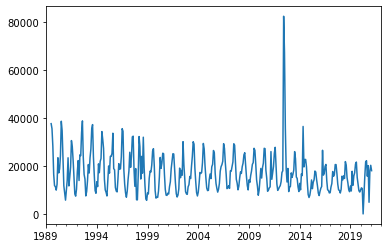

In [29]:
revised_or_park_visits.iloc[:,0].plot()

Well that's a strange spike, but it does look like we have data alright. Let's put this in a dataset

In [36]:
or_park_visits_ds = xr.Dataset(
    coords = dict(
        time = revised_or_park_visits.index,
        park = or_parks,
    ),
    data_vars = dict(
        day_user=(["time", "park"], revised_or_park_visits.values)
    )
)
or_park_visits_ds

<xarray.Dataset>
Dimensions:   (time: 397, park: 259)
Coordinates:
  * time      (time) datetime64[ns] 1989-01-01 1989-02-01 ... 2022-01-01
  * park      (park) <U74 'AGATE BEACH STATE RECREATION SITE' ... 'TOTAL: REG...
Data variables:
    day_user  (time, park) object nan nan nan nan nan ... nan nan nan nan nan

In [37]:
or_park_visits_ds['day_user'].attrs = {
    "Source": "Oregon Parks and Recreation",
    "Original Download": "3/12/21 by K.Hegewisch from Chris Havel (chris.havel@oregon.gov)(OPR)",
    "Reformatted": "2/17/22 by A. Stein",
}

In [39]:
revised_or_park_visits = pd.DataFrame(index=pd.date_range(start=f"{or_years[0]}", end=f"{or_years[-1]+1}", freq="MS"), columns=or_parks)

errors = []

for dex in or_overnight_monthly.index:
    park = dex[0].upper()
    month_num = dex[1]
    year = dex[2]
    #try:
    revised_or_park_visits[park].loc[f'{year}-{month_num}-01'] = or_overnight_monthly.loc[dex, 'attendance']
    #except:
    #    errors.append((park, year, month))

or_park_visits_ds['overnight'] = (['time','park'], revised_or_park_visits.values)

In [40]:
or_park_visits_ds['overnight'].attrs = {
    "Source": "Oregon Parks and Recreation",
    "Original Download": "3/12/21 by K.Hegewisch from Chris Havel (chris.havel@oregon.gov)(OPR)",
    "Reformatted": "2/17/22 by A. Stein",
}

In [41]:
or_park_visits_ds

<xarray.Dataset>
Dimensions:    (time: 397, park: 259)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-02-01 ... 2022-01-01
  * park       (park) <U74 'AGATE BEACH STATE RECREATION SITE' ... 'TOTAL: RE...
Data variables:
    day_user   (time, park) object nan nan nan nan nan ... nan nan nan nan nan
    overnight  (time, park) object nan nan nan nan nan ... nan nan nan nan nan

In [42]:
save_path = '/pool0/home/steinadi/data/drought/drought_impact/data/or_state_parks.nc'

try:
    os.remove(save_path)
except:
    pass
or_park_visits_ds.to_netcdf(save_path)